## Import

In [1]:
from gemseo import generate_coupling_graph
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

## Discipline

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

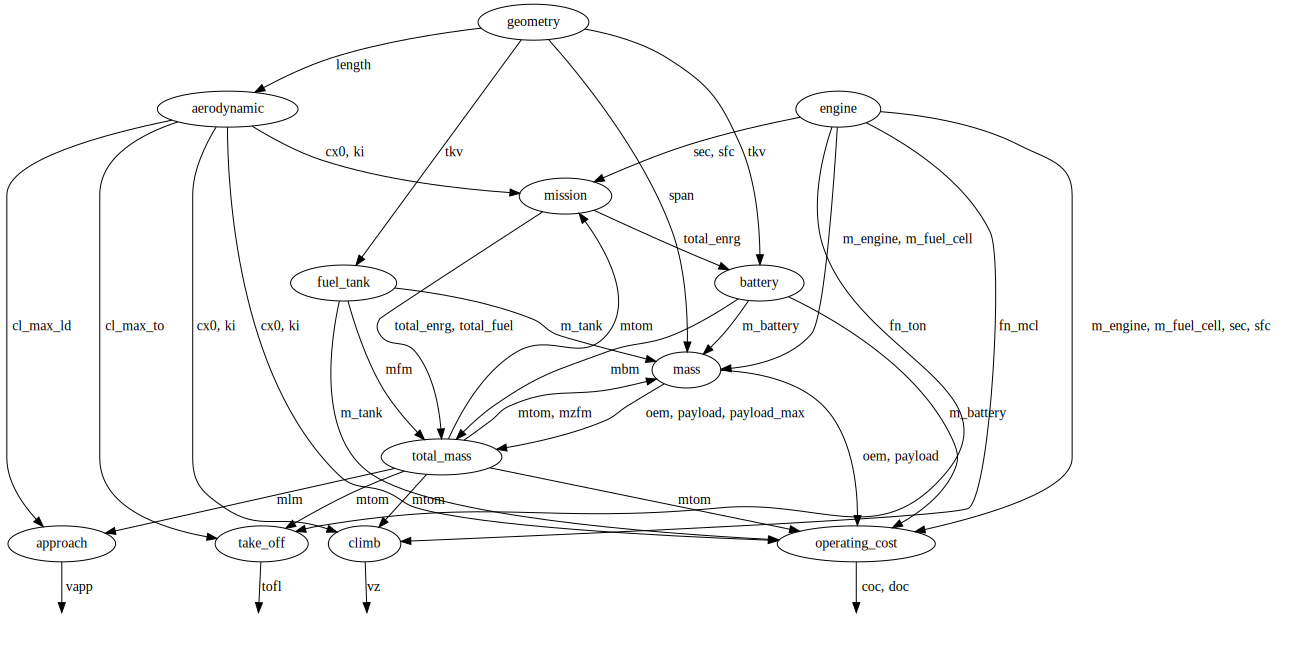

In [4]:
generate_coupling_graph(disciplines)

## Design Space

In [5]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [6]:
from gemseo.algos.parameter_space import ParameterSpace

uncertain_space = ParameterSpace()
uncertain_space.add_variable("slst", value=convert_from("kN",150))
uncertain_space.add_variable("n_pax", value=150.0)
uncertain_space.add_variable("area", value=180.0)
uncertain_space.add_variable("ar", value=9.0)



uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)



## Scenario

In [7]:
scenario = MDOScenario(disciplines, "mtom", uncertain_space, formulation_name="MDF")

In [8]:
scenario.add_constraint("tofl", constraint_type="ineq", positive=False, value=1900.)
scenario.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from('kt',135.0))
scenario.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from('ft/min',300.0))
scenario.add_constraint("span", constraint_type="ineq", positive=False, value=40.0)
scenario.add_constraint("length", constraint_type="ineq", positive=False, value=45.0)
scenario.add_constraint("fm", constraint_type="ineq", positive=True, value=0.0)

In [9]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=100)


    INFO - 14:57:22: *** Start MDOScenario execution ***
    INFO - 14:57:22: MDOScenario
    INFO - 14:57:22:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:57:22:    MDO formulation: MDF
    INFO - 14:57:22: Optimization problem:
    INFO - 14:57:22:    minimize mtom(slst, n_pax, area, ar, aef, cef, sef)
    INFO - 14:57:22:    with respect to aef, ar, area, cef, n_pax, sef, slst
    INFO - 14:57:22:    subject to constraints:
    INFO - 14:57:22:       tofl(slst, n_pax, area, ar, aef, cef, sef) <= 1900.0
    INFO - 14:57:22:       vapp(slst, n_pax, area, ar, aef, cef, sef) <= 69.44999999400001
    INFO - 14:57:22:       vz(slst, n_pax, area, ar, aef, cef, sef) >= 1.524
    INFO - 14:57:22:       span(slst, n_pax, area, ar, aef, cef, sef) <= 40.0
    INFO - 14:57:22:       length(slst, n_pax, area, ar, aef, cef, sef) <= 45.0
    INFO - 14:57:22:       fm(slst, n_pax, area, ar, aef, cef, sef) >

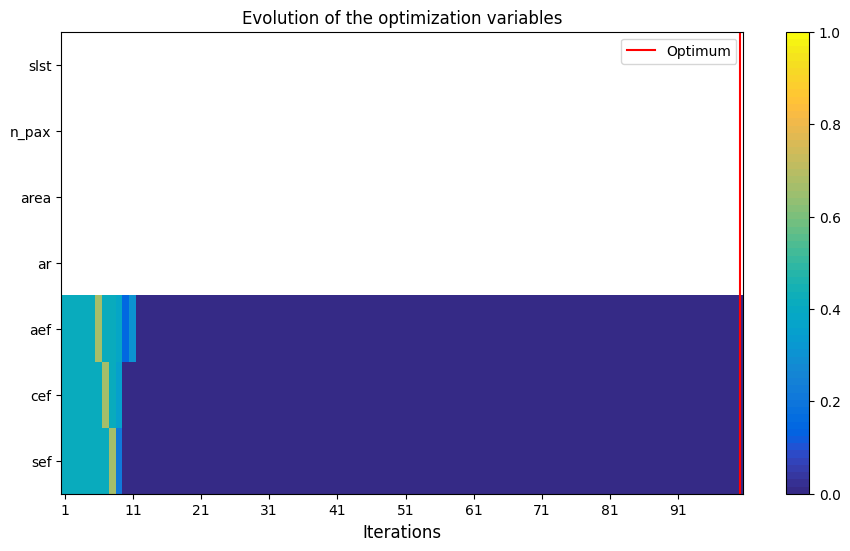

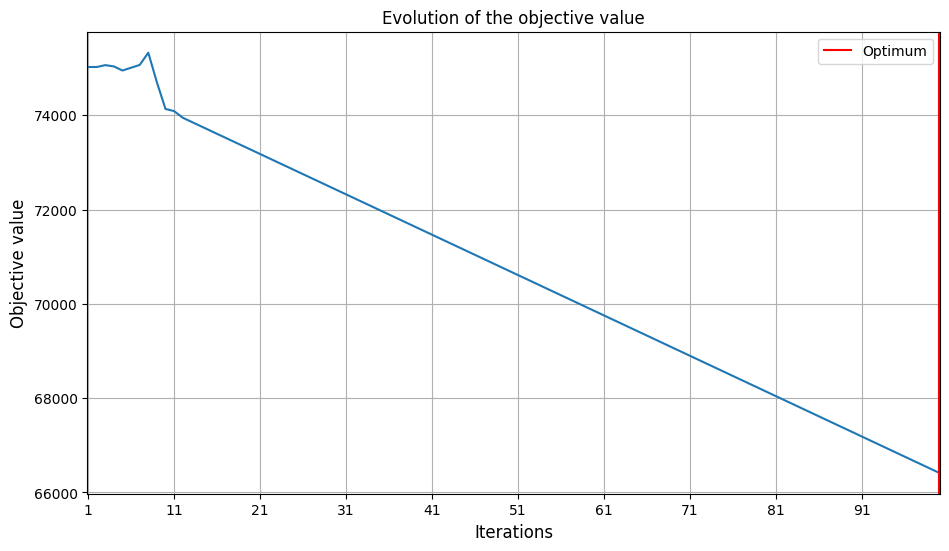

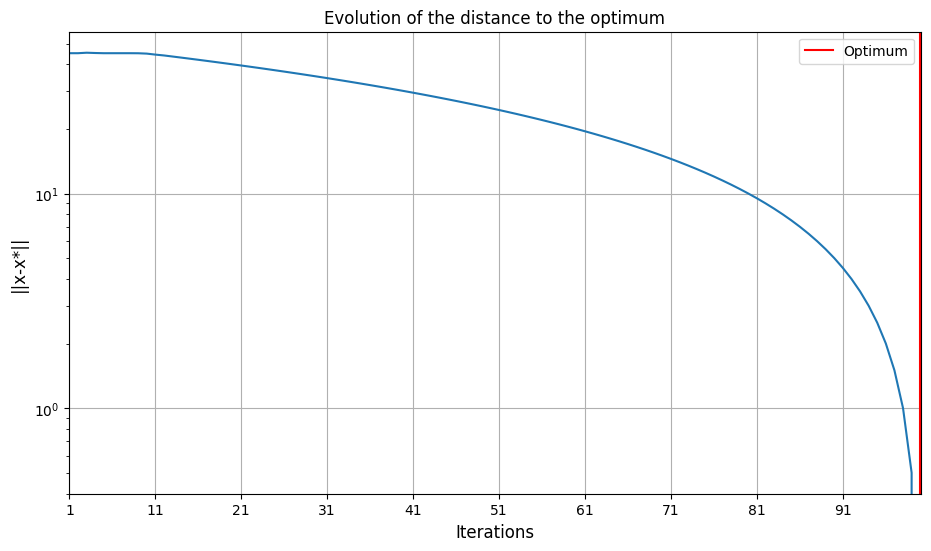

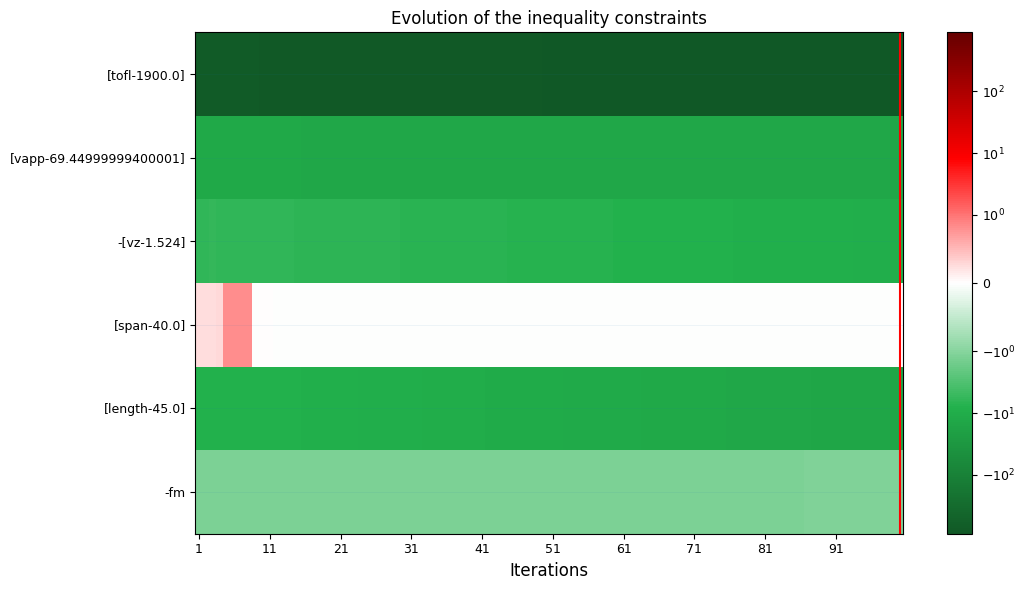

In [10]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)


In [12]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline


In [24]:
training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_OPT_LHS", n_samples=20)
test_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_FULLFACT", n_samples=30)

    INFO - 15:13:12: *** Start Sampling execution ***
    INFO - 15:13:12: Sampling
    INFO - 15:13:12:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:13:12:    MDO formulation: MDF
    INFO - 15:13:12: Running the algorithm OT_OPT_LHS:
    INFO - 15:13:13:    100%|██████████| 20/20 [00:00<00:00, 26.01 it/sec]
    INFO - 15:13:13: *** End Sampling execution (time: 0:00:00.795384) ***
    INFO - 15:13:13: *** Start Sampling execution ***
    INFO - 15:13:13: Sampling
    INFO - 15:13:13:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:13:13:    MDO formulation: MDF
    INFO - 15:13:13: Running the algorithm OT_FULLFACT:
    INFO - 15:13:13:    100%|██████████| 1/1 [00:00<00:00, 28.11 it/sec]oes not exist; use 1 samples instead, i.e. the largest 7-th integer power less than 30.
    INFO - 15:13:13: *** End 

In [25]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [26]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)


{'fm': array([1.]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [27]:
r2.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.94154714]),
 'length': array([0.96076427]),
 'mtom': array([-0.14579749]),
 'span': array([0.85382487]),
 'tofl': array([-1.45751715]),
 'vapp': array([-1.28795509]),
 'vz': array([-0.64063017])}

In [28]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)


{'fm': array([1.19131566e-05]),
 'length': array([0.00114635]),
 'mtom': array([94.25214512]),
 'span': array([0.0275579]),
 'tofl': array([6.02082313e+12]),
 'vapp': array([606.73180868]),
 'vz': array([391.23074159])}

In [29]:
rmse.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.00011864]),
 'length': array([0.00968358]),
 'mtom': array([975.78199385]),
 'span': array([0.09179152]),
 'tofl': array([4.27140189e+13]),
 'vapp': array([4263.06605361]),
 'vz': array([3260.07355347])}

In [ ]:
scenario_surrogate = MDOScenario([surrogate_discipline], "mtom", uncertain_space, formulation_name="MDF")
scenario_surrogate.add_constraint("tofl", constraint_type="ineq", positive=False, value=1900.)
scenario_surrogate.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from('kt',135.0))
scenario_surrogate.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from('ft/min',300.0))
scenario_surrogate.add_constraint("span", constraint_type="ineq", positive=False, value=40.0)
scenario_surrogate.add_constraint("length", constraint_type="ineq", positive=False, value=45.0)
scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=True, value=0.0)

 WARNING - 15:13:24: No coupling in MDA, switching chain_linearize to True.


In [ ]:
scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)


    INFO - 15:14:16: *** Start MDOScenario execution ***
    INFO - 15:14:16: MDOScenario
    INFO - 15:14:16:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:14:16:    MDO formulation: MDF
    INFO - 15:14:16: Optimization problem:
    INFO - 15:14:16:    minimize mtom(slst, n_pax, area, ar, aef, cef, sef)
    INFO - 15:14:16:    with respect to aef, ar, area, cef, n_pax, sef, slst
    INFO - 15:14:16:    subject to constraints:
    INFO - 15:14:16:       tofl(slst, n_pax, area, ar, aef, cef, sef) <= 1900.0
    INFO - 15:14:16:       vapp(slst, n_pax, area, ar, aef, cef, sef) <= 69.44999999400001
    INFO - 15:14:16:       vz(slst, n_pax, area, ar, aef, cef, sef) >= 1.524
    INFO - 15:14:16:       span(slst, n_pax, area, ar, aef, cef, sef) <= 40.0
    INFO - 15:14:16:       length(slst, n_pax, area, ar, aef, cef, sef) <= 45.0
    INFO - 15:14:16:       fm(slst, n_pax, area, ar, aef, cef, sef) >

KeyboardInterrupt: 

In [ ]:
scenario_surrogate.post_process(post_name="OptHistoryView", save=False, show=True)